# Kanapy – Generation of voxelized RVE
Generate a representatative volume element (RVE) for a synthetic microstructure and export geometry as Abaqus INP file. Generate orientation for each grain in form of Euler angles that are characteristic for a given crystallographic texture.


Author: Alexander Hartmaier, ICAMS / Ruhr-University Bochum, Germany<br>
Copyright &copy; by the author, August 2025

### 1. Import required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import kanapy as knpy
from math import pi
if int(knpy.__version__[0]) < 6 or int(knpy.__version__[2]) < 1:
    raise ModuleNotFoundError(f'Kanapy version 6.1. or higher is required. Current version is {knpy.__version__}. Please update Kanapy')
print(f'Kanapy version {knpy.__version__}')

Kanapy version 6.5.2


## 2. Create geometric representation of microstructure
The microstructure generation of Kanapy is based on statsical descriptors, in form of a dictionary. These descriptors can be generated directly, as described in the following, or be imported from an EBSD map, see [ebsd2rve.ipynb](ebsd2rve.ipynb). Based on these descriptors, a simulation box filled with a set of spherical or ellipsoidal particles is created. These initally downsized particles move freely in the simulation box, only subject to collissions. During their motion, the particles are growing until a dense packing in the simulation box is achieved. After that "packing" step, a regular grid of voxels is generated in the simulation box and each voxel is assigned to a grain. Following this "voxelization", and optional step can be exectued to generate polyhedral hulls aroung the voxelized grains and to analyze the geometrical statistics of the microstructure. After this, the geometry module of Kanapy is completed and the texture module can be invoked. There are different output formats available in which the resulting RVE can be exported to further use it with other software packages. These steps are executed and explained in detail in the following.

### 2.1. Generate statistical descriptors
Here, an example for statistical descriptors for a polycrystal with elongated grains is provided.


In [2]:
# Basic definitions
matname = 'Austenite fcc'
matnumber = 4  # UMAT number for fcc Iron
deg = pi/180.0

# RVE and microstructure parameters
Nv = 30  # number of voxels along each Cartesian direction
size = 40  # size of RVE in micron
periodic = True  # periodicity of microstructure
ms_elong = {'Grain type': 'Elongated',
          'Equivalent diameter': {'sig': 0.8, 'scale': 14.0, 'cutoff_min': 8.0, 'cutoff_max': 18.0},
          'Aspect ratio': {'sig':0.8, 'scale': 1.5, 'cutoff_min': 0.9, 'cutoff_max': 3.5},
          'Tilt angle': {'kappa': 1.0, 'loc': 90.*deg, "cutoff_min": 0.0, "cutoff_max": 180.0*deg},
          'RVE': {'sideX': size, 'sideY':size, 'sideZ': size, 'Nx': Nv, 'Ny': Nv, 'Nz': Nv, 'ialloy': matnumber},
          'Simulation': {'periodicity': periodic, 'output_units': 'um'},
          'Phase': {'Name': matname, 'Number': 0, 'Volume fraction': 1.0}}

### 2.2. Microstructure object
Using the `Microstructure` class of Kanapy, a microstructure object is generated, by passing the microstructure descriptors 'ms_elong' as input data to this class. The Python dictionary 'ms_elong' also contains the geometrical definition of the RVE box. Note that for dual-phase microstructure, a list of descriptors for each phase can be passed.  
After this, the method `plot_stats_init()` plots the statistical distributions that will be used for the particle simulation. The region between the lower and upper cutoffs is highlighted in the plot. By adapting these cutoffs, a proper match between input and output statistics can be achieved, as seen later on, when the microstructure descriptors of the RVE are analyzed. Then, the method `init_RVE()` creates the simulation box and a particle set that fulfills the required size distribution within the given lower (dashed vertical line) and upper (solid vertical line) bound.  


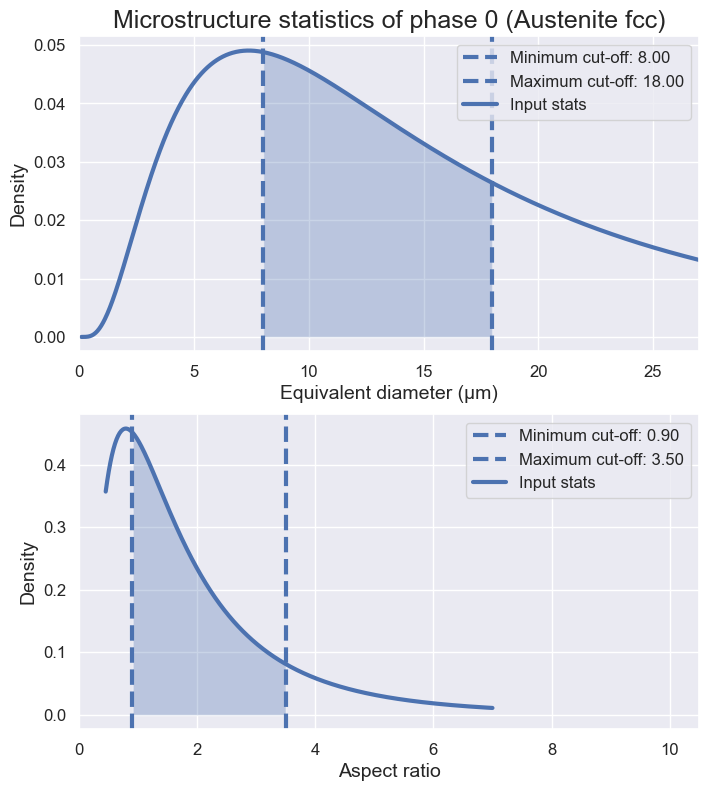

Creating an RVE based on user defined statistics
    Analyzed statistical data for phase Austenite fcc (0)
    Total number of particles  = 56
  RVE characteristics:
    RVE side lengths (X, Y, Z) = (40, 40, 40) (um)
    Number of voxels (X, Y, Z) = (30, 30, 30)
    Voxel resolution (X, Y, Z) = [1.3333 1.3333 1.3333](um)
    Total number of voxels     = 27000


Considered phases (volume fraction): 
0: Austenite fcc (100.0%)




In [3]:
ms = knpy.Microstructure(descriptor=ms_elong, name=matname)
ms.plot_stats_init()  # plot initial statistics of equivalent grain diameter and aspect ratio
ms.init_RVE()  # initialize RVE including particle distribution

### 2.3 Packing simulation
In the second step, the particle simulation is performed by invoking the method `pack()`. To accomplish this, the particles generated in the last step are initally downscaled in size by a factor of 100 such that they can move freely through the simulation box but still fulfill the same charactistics of the size distribution with larger and smaller particles in the desired quantities. To avoid overlap of particles, collsions are considered. In this way, the particles form a realistic distribution within the space of the simulation box, as can be verified in the plot by `plot_ellipsoids()`.  
**Note:** As the particle simulations can be quite time consuming, particle configurations can be saved by passing the optional argument "save_files=True" to the `pack()`method. Then, the last particle file can be imported with the `import_particles()` method. The particles are saved a "dump" files that can also be imported and visualized with the Software package [Ovito](https://ovito.org), see also the section "Visualize the packing simulation" in the [Kanapy documentation](https://icams.github.io/Kanapy/builds/html/usage.html#visualize-the-packing-simulation).


Starting particle simulation
    Creating particles from distribution statistics
    Total volume of generated ellipsoids: 66154.81471275583
    Particle packing by growth simulation
Volume of simulation box: 64000
Volume of unscaled particles: 66154.81471275583
Initial volume of scaled ellipsoids: 66.15481471275585, targeted final volume: 43000.629563291295
Volume increment per time step: 66.15481471275584


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1441/1441 [00:19<00:00, 72.10it/s]


Actual final volume of ellipsoids: 42942.69861079759
Completed particle packing
197 overlapping particles detected after packing
Kinetic energy of particles after packing: 311985.4035124476



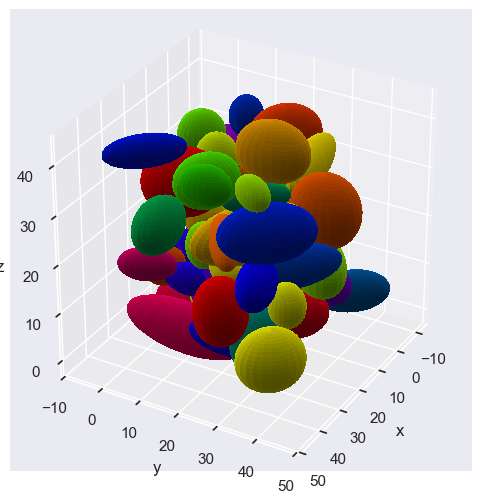

In [14]:
ms.pack()  # perform particle simulation to distribute grain nuclei in RVE volume
# **Alternative:** read particles from dump file, instead of executing ms.pack()
# Requires prior exection with particle save option activated: "ms.pack(save_files=True)"
# Import with: "ms.import_particles('dump_files/particle.699.dump')"
ms.plot_ellipsoids()  # plot final configuration of particles

### 2.4. Voxelization
After the generation of the particle distribution of the desired volume fraction statistical distribution of particles, the method `voxelize()` generates a voxelated structure in form of a regular 3D mesh of the simulation box. Each voxel lying inside a particle will be assigned to this grain. The remaining voxels will be assigned to the grains according to a growth and distribution algorithm.  
In the figure created by the `plot_voxels()` method, the individual grains are represented in arbitrary colors. With the optional argument "sliced" either the full RVE can be plotted (default) or one octand can be removed from the plot (sliced=True) to get an view into th einternal of the RVE.


    Generating voxels inside RVE

Starting RVE voxelization
    Assigning voxels to grains


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27000/27000 [00:00<00:00, 43979109.90it/s]
INFO:root:Removing polyhedral grain geometries and statistical data after re-meshing.


Completed RVE voxelization



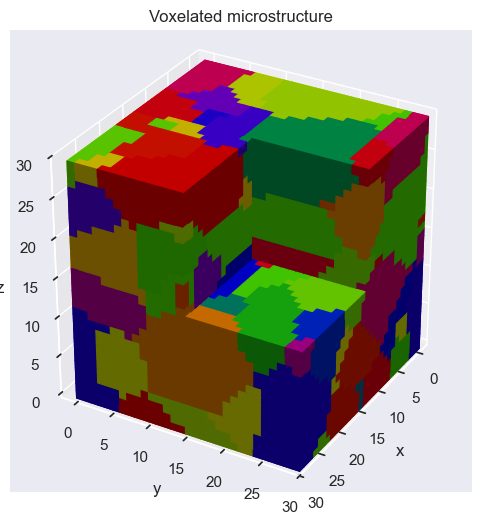

In [15]:
ms.voxelize()  # create structured mesh and assign voxels to grains according to particle configuration
# at this point, the mesh can be re-defined with the optional argument "dim", e.g. "ms.voxelize(dim=(30,30,30))"
ms.plot_voxels(sliced=True)  # plot voxels colored according to grain number

### 2.5. Show statistics of microstructure in RVE
The grain geometry in the voxelized 3D microstructure (representative volume element, RVE) will be analysed statistically with respect to the grain size distribution and the aspect ratio distribution. This is accomplished by constructing the smallest cuboid containing the voxels of each grain and analyzing the statistical parameters of the distribution of semi-axes of all cuboids. From these statistical data of the semi-axes, descriptors of the 3D microstructure with respect to grain size and aspect ratio distributions are gathered. The results are plotted with the `plot_stats_init(show_res=True)` method, which compares the resulting grain microstructure statistics of the voxelized RVE with that of the original descriptors. Note that the choice of the cutoffs has a big influence on the output statistics such that this parameters can be used to match botch, input and output statistics in the best possible way. 

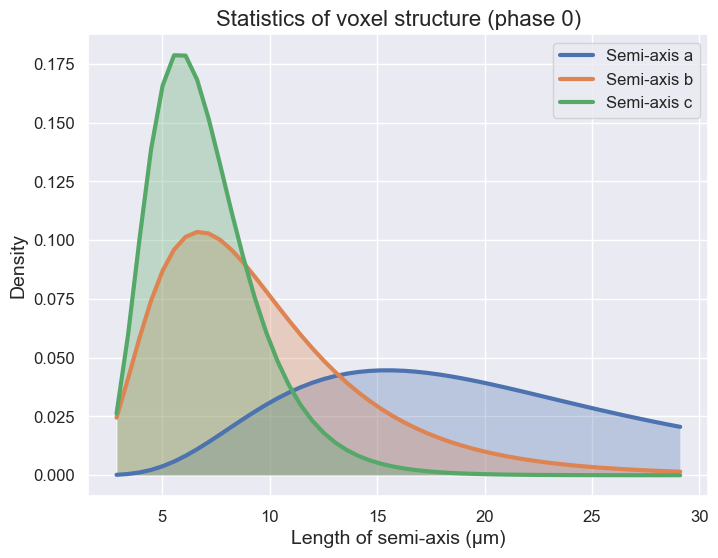


Statistical microstructure parameters of RVE
--------------------------------------------
Type	| a (µm) 	| b (µm) 	| c (µm) 	| std.dev	| rot.axis	| asp.ratio	| std.dev	| equ.dia. (µm)	| std.dev
Input	|  -      	|  -      	|  -      	|   -      	|     -   	|  1.500	|  0.8000	|     14.000 	|  0.8000
Output	|  20.022	|  8.696	|  6.600	|  0.4561	|     0   	|  2.618	|  0.5648	|     19.421 	|  0.4071


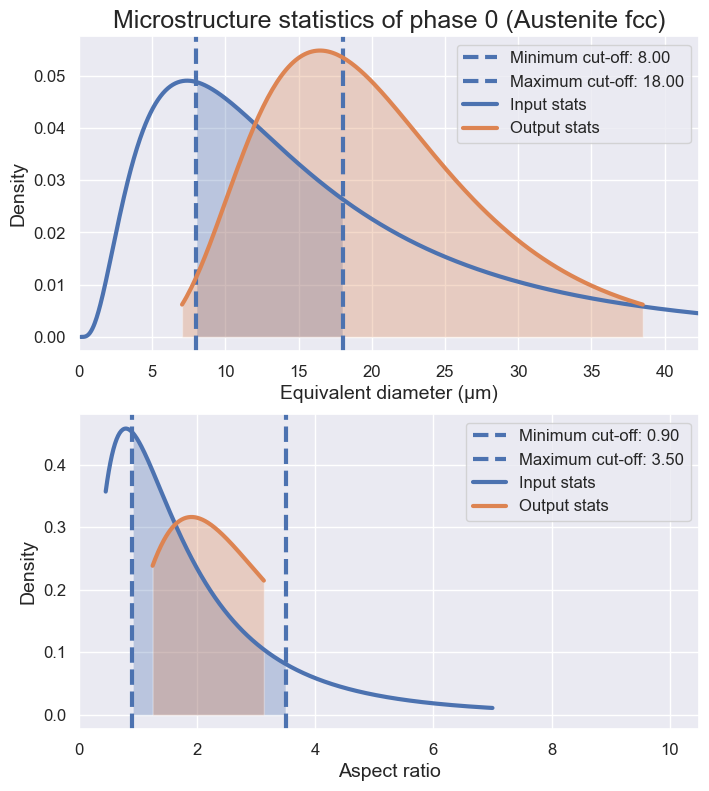

In [16]:
ms.plot_stats_init(show_res=True)  # compare final grain statistics with initial parameters

### 2.6. Generate polyhedral grains
In this optional step, running the `generate_grains()` method of the microstructure object performs a Delaunay tesseleation of the voxel structure by which a ployhedral hull around each grain is constructed. The resulting polyhedral representation of the microstructure can be plotted with the `plot_grains()` method.  



Generated Delaunay tesselation of grain vertices.
Assigning 2022 tetrahedra to grains ...


2022it [00:11, 176.93it/s]


Finished generating polyhedral hulls for grains.
Total volume of RVE: 64000 um^3
Total volume of polyhedral grains: 63999.999999999985 um^3
Mean relative error of polyhedral vs. voxel volume of individual grains: 0.172
for mean volume of grains: 1142.857 um^3.


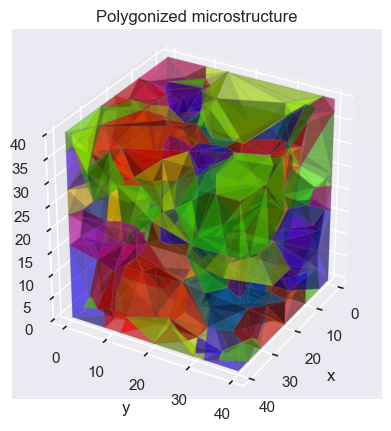

In [17]:
ms.generate_grains()  # generate a polyhedral hull around each voxelized grain
ms.plot_grains()  # plot polyhedral grains


It is seen that the particle and grain statistics do not match quantitatvely. In particular the cut-off values can be used to dreate a desired 3D microstructure in an iterative procedure.

### 3. Generate set of grain orientations for specified texture
In this step, the texture module of Kanapy is invoked to assign a crystallographic orientation to each grain. The grain orientations are generated in form of Euler angles with the method `ms.generate_orientations()`, which is based on the Matlab package [MTEX](https://mtex-toolbox.github.io). The parameter 'tdesc' needs to be specifoed. This parameter can be set as 'unimodal' in which case a (list of) Euler angles for a unimodal (multimodal) texture and a kernel halwidth must be provided. If tdesc is set to the value 'random', a random texture will be generated. The required grain boundary texture is defined in form of a histogram.  
**Note 1:** All angles are specified in degrees.  
**Note 2:** In some cases the texture module fails if grain boundaries are not detected properly in the voxelization step. In this case, please repeat all steps from 2.3 Packing simulation.


In [22]:
texture = 'goss' # Implemented textures are goss, copper, random
mdf = 'high'
# define standard parameters for misorientation distribution functions
"""Test cases for misorientation distribution (MDF) adapted from
Miodownik, M., et al. "On boundary misorientation distribution functions
and how to incorporate them into three-dimensional models of microstructural
evolution." Acta materialia 47.9 (1999): 2661-2668.
https://doi.org/10.1016/S1359-6454(99)00137-8
"""
mdf_freq = {
  "high": [0.0013303016, 0.208758929, 0.3783092708, 0.7575794912, 1.6903069613,
           2.5798481069, 5.0380640643, 10.4289690569, 21.892113657, 21.0,
           22.1246762077, 13.9000439533],
  "low":  [4.5317, 18.6383, 25, 20.755, 12.5984, 7.2646, 4.2648, 3.0372, 2.5,
           1, 0.31, 0.1],
  "random": [0.1, 0.67, 1.9, 3.65, 5.8, 8.8, 11.5, 15.5, 20, 16.7, 11.18, 4.2]
}
mdf_bins = np.linspace(62.8/12,62.8,12)

# generate grain orientations and write ang file
"""
Different textures can be choosen and assinged to the RVE geometry that has
been defined above.
Texture is defined by the orientation of the ideal component in Euler space
ang and a kernel halfwidth omega. Kernel used here is deLaValleePoussin.
The function createOriset will first create an artificial EBSD by sampling
a large number of discrete orientations from the ODF defined by ang and
omega. Then a reduction method is applied to reconstruct this initial ODF
with a smaller number of discrete orientations Ngr. The reduced set of
orientations is returned by the function.
For more information on the method see:
https://doi.org/10.1107/S1600576719017138
"""
if texture.lower() == 'goss':
    ang = [0, 45, 0]    # Euler angle for Goss texture
    omega = 7.5         # kernel half-width
    tdesc = 'unimodal'
elif texture.lower() == 'copper':
    ang = [90, 35, 45]
    omega = 7.5
    tdesc = 'unimodal'
elif texture.lower() == 'random':
    ang = None
    omega = None
    tdesc = 'random'
else:
    raise ValueError('Texture not defined. Take goss, copper or random')
if knpy.__backend__ == 'mtex':
    ms.generate_orientations(tdesc, ang=ang, omega=omega, 
                             hist=mdf_freq[mdf], Nbase=1000)
else:
    ms.generate_orientations(tdesc, ang=ang, omega=omega, Nbase=1000)


INFO:root:Using ORIX library to read EBSD maps and generate orientations.


<class 'NoneType'>


After generating the orientations, the voxelated structure can be plotted with grains colored accoring to IPF key.  
**Note:** This option requires the full kanapy installation with MTEX.

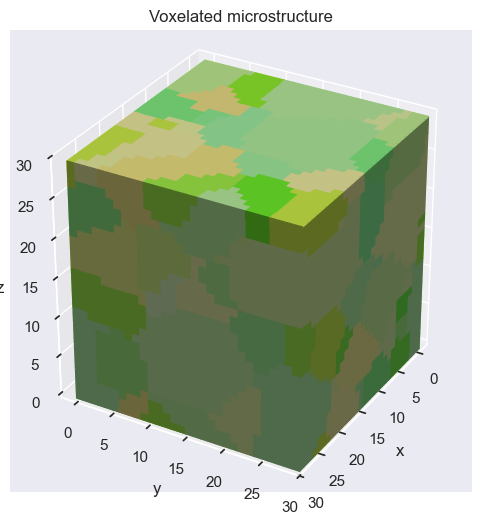

In [23]:
ms.plot_voxels(ori=True)

### 4. Write Abaqus input deck
The geometrical information of the RVE is exported as Abaqus input file with the ending "_geom.inp" by the method `write_abq()`. This input deck defines a finite element for each voxel. Furthermore, for each grain a set of elements is defined and assigned to a user defined material with the name "GRAIN{grain_id}_MAT". By the same method, the information on the grain orientations is exported as Abaqus input file with the ending "_mat.inp". This file contains the information on the material number to be used in the ICAMS Crystal Plasticity UMAT and the Euler angles for each grain, identified by the name "GRAIN{grain_id}_MAT". The _geom.inp file contains an *INCLUDE command to read the material definitions in the _mat.inp file.

In [24]:
# write Abaqus input file for voxelated geometry (_geom.inp) and Euler angles (_mat.inp)
ptag = 'pbc' if periodic else 'no_pbc'
fname = ms.write_abq(nodes='v', file=f'abq{Nv}_gr{ms.Ngr}_{ptag}_geom.inp')


Writing RVE as ABAQUS file "./abq30_gr56_pbc_geom.inp"
Using brick element type C3D8.
---->DONE! 



## 5. Export voxel file
With the method `write_voxels()` the information about geometry of the voxel structure and the grain orientations are written into a JSON file, which can be re-imported into Kanapy to safe the packing and voxelization steps, as demonstrated below.

In [25]:
# Save Kanapy microstructure as voxel file
ms.write_voxels(file=f'{matname}_voxels.json', script_name='generate_rve.ipynb', mesh=False, system=False)

Writing voxel information of microstructure to ./Austenite fcc_voxels.json.


### 5.1 Import voxel file

JSON files with voxel structures can be imported instead of RVE generation and processed further. Note that also the grain orientations ar estored in the JSON file and can be recaptured. 

Creating an RVE from voxel input
  RVE characteristics:
    RVE side lengths (X, Y, Z) = (40, 40, 40) (um)
    Number of voxels (X, Y, Z) = (30, 30, 30)
    Voxel resolution (X, Y, Z) = [1.3333 1.3333 1.3333](um)
    Total number of voxels     = 27000


Considered phases (volume fraction): 
0: Austenite fcc (100.0%)


    Generating voxels inside RVE

 Voxel structure imported.



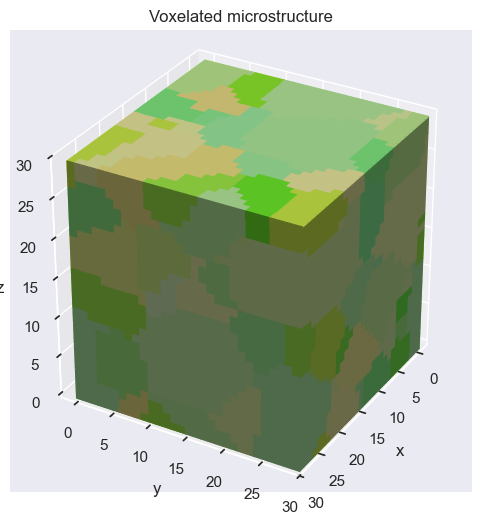

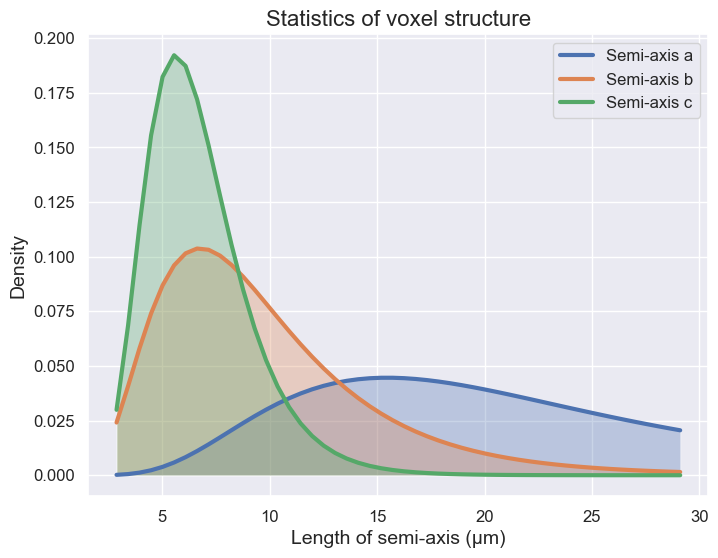


Statistical microstructure parameters of RVE
--------------------------------------------
Type	| a (µm) 	| b (µm) 	| c (µm) 	| std.dev	| rot.axis	| asp.ratio	| std.dev	| equ.dia. (µm)	| std.dev
Voxels	|  20.017	|  8.696	|  6.342	|  0.4520	|     0   	|  2.662	|  0.5770	|     19.421 	|  0.4071


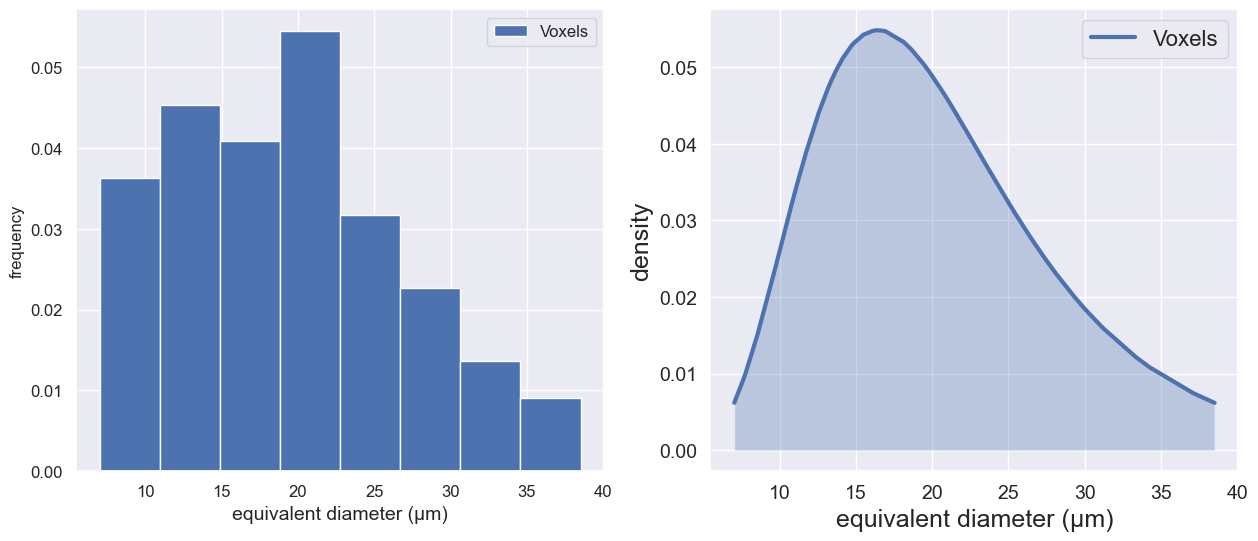

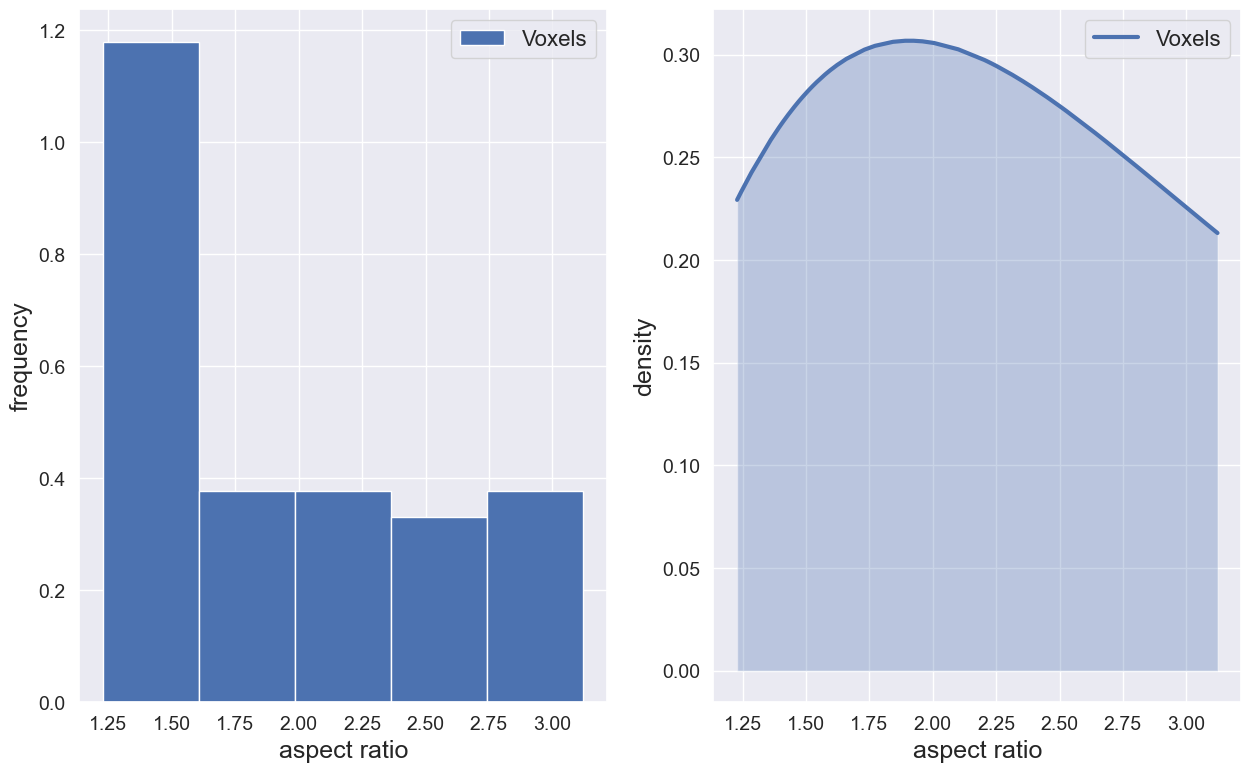

In [26]:
ms2 = knpy.import_voxels(f'{matname}_voxels.json')
ms2.plot_voxels(ori=True)
ms2.plot_stats(show_all=True)